In [32]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Markov chain Monte Carlo method for inference of stochastic block models
From the paper [Overview of Peixoto’s Monte Carlo Method for Inference of SBMs](https://www.ricardobatista.com/presentations/Overview%20of%20Peixoto%E2%80%99s%20MC%20Method%20for%20Inference%20of%20SBMs%20%283.21.2018%29.pdf)

### Initializing the partition
The initial partition is randomly generated. Each node is assigned to a community, and the number of communities
num_community is predefined. This partition is represented by an array where each index corresponds to a node and each value to the block assigned to this node.

In [33]:
def initial_partition(num_nodes, num_communities):
    return np.random.randint(0, num_communities, size=num_nodes)

### Modifying the partition

The **propose_new_partition** function generates a new partition by changing the block of a randomly selected node. The node is moved to a different block than the one it currently belongs to, providing variation in the partition structure


In [34]:
def propose_new_partition(partition, n_blocks, n_nodes):
    new_partition = partition.copy()
    node = np.random.randint(n_nodes) 
    current_block = partition[node]
    possible_blocks = list(set(range(n_blocks)) - {current_block})
    new_partition[node] = np.random.choice(possible_blocks)
    return new_partition

### Calculation of likelihood

The **calculate_likelihood** function evaluates the likelihood of a node partition in a network, specifically focusing on intra-community and inter-community links. The function then calculates the probabilities of these links, namely the probability that two connected nodes belong to the same community (p_intra) or different communities (p_inter). It uses these probabilities to compute the logarithm of the likelihood, where positive contributions come from intra-community links and negative contributions from inter-community links, adjusted to avoid mathematical errors with a small epsilon term. This approach rewards partitions where nodes within the same community are more interconnected than with those from other communities, thus reflecting a distinct and coherent community structure.

In [35]:
def calculate_likelihood(adj_matrix, partition, num_communities):
    num_nodes = adj_matrix.shape[0]
    intra_links, inter_links = 0, 0
    total_intra, total_inter = 0, 0

    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):  
            if partition[i] == partition[j]:
                intra_links += adj_matrix[i][j]
                total_intra += 1
            else:
                inter_links += adj_matrix[i][j]
                total_inter += 1

    
    p_intra = (intra_links / total_intra) if total_intra > 0 else 0
    p_inter = (inter_links / total_inter) if total_inter > 0 else 0
    epsilon = 1e-10  
    log_likelihood = intra_links * np.log(p_intra + epsilon) + inter_links * np.log(p_inter + epsilon)
    return log_likelihood


### Metropolis Algorithm

The **metropolis_algorithm** function implements the Metropolis algorithm to infer community structures in a network, based on an adjacency matrix and a specified number of communities. It starts by randomly initializing a partition of the network nodes into communities. In each iteration of the algorithm, a new partition is proposed by randomly changing the community of a node. The likelihood of this new partition is then calculated and compared to the current partition's likelihood. The new partition is accepted with a probability that depends on the increase in likelihood. This process repeats for a specified number of iterations, allowing the algorithm to explore the space of possible partitions and gradually converge towards a configuration that maximizes the likelihood of internal links over external links, thus revealing the community structure of the network.

In [36]:
def metropolis_algorithm(adj_matrix, num_communities, num_iterations=10000, cooling_rate=0.995):
    num_nodes = adj_matrix.shape[0]
    current_partition = np.random.choice(num_communities, num_nodes, replace=True)
    current_likelihood = calculate_likelihood(adj_matrix, current_partition, num_communities)

    for iteration in range(num_iterations):
        new_partition = propose_new_partition(current_partition, num_communities, num_nodes)
        
        new_likelihood = calculate_likelihood(adj_matrix, new_partition, num_communities)
        delta_likelihood = new_likelihood - current_likelihood
        
        # Acceptance probability 
        if np.random.rand() < np.exp(delta_likelihood):
            current_partition = new_partition
            current_likelihood = new_likelihood

    return current_partition

In [37]:
def draw(current_partition, G, method):
    color_map = [f"C{p}" for p in current_partition]
    pos = nx.spring_layout(G)
    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, node_color=color_map, with_labels=True, edge_color='gray')
    plt.title(method)
    plt.show()


### Metropolis-Hasting Algorithm

In [38]:
def propose_new_partition_for_hasting(current_partition, adj_matrix, num_communities, num_nodes):
    new_partition = current_partition.copy()
    node = np.random.randint(num_nodes)
    current_community = current_partition[node]

    # Calculer les poids pour chaque communauté basée sur les liens
    community_weights = np.zeros(num_communities)
    for neighbor in range(num_nodes):
        if adj_matrix[node][neighbor] > 0:  # Il y a une connexion
            community_weights[current_partition[neighbor]] += adj_matrix[node][neighbor]

    # Exclure la communauté actuelle pour encourager l'exploration
    community_weights[current_community] = 0
    if community_weights.sum() > 0:
        community_weights /= community_weights.sum()
    else:
        community_weights = np.ones(num_communities) / num_communities  # Uniforme si isolé

    new_community = np.random.choice(range(num_communities), p=community_weights)
    new_partition[node] = new_community

    # Assumer des propositions symétriques pour simplifier
    forward_proposal = community_weights[new_community]
    reverse_proposal = 1 / (num_communities - 1)  # Simplification

    return new_partition, forward_proposal, reverse_proposal

def metropolis_hastings_algorithm(adj_matrix, num_communities, num_iterations=10000, beta=0.1):
    num_nodes = adj_matrix.shape[0]
    current_partition = np.random.choice(num_communities, num_nodes, replace=True)
    current_likelihood = calculate_likelihood(adj_matrix, current_partition, num_communities)

    for _ in range(num_iterations):
        new_partition, forward_proposal, reverse_proposal = propose_new_partition_for_hasting(current_partition, adj_matrix, num_communities, num_nodes)
        new_likelihood = calculate_likelihood(adj_matrix, new_partition, num_communities)
        delta_likelihood = new_likelihood - current_likelihood

        acceptance_ratio = (np.exp(beta * delta_likelihood) * reverse_proposal) / forward_proposal
        if np.random.rand() < acceptance_ratio:
            current_partition = new_partition
            current_likelihood = new_likelihood

    return current_partition


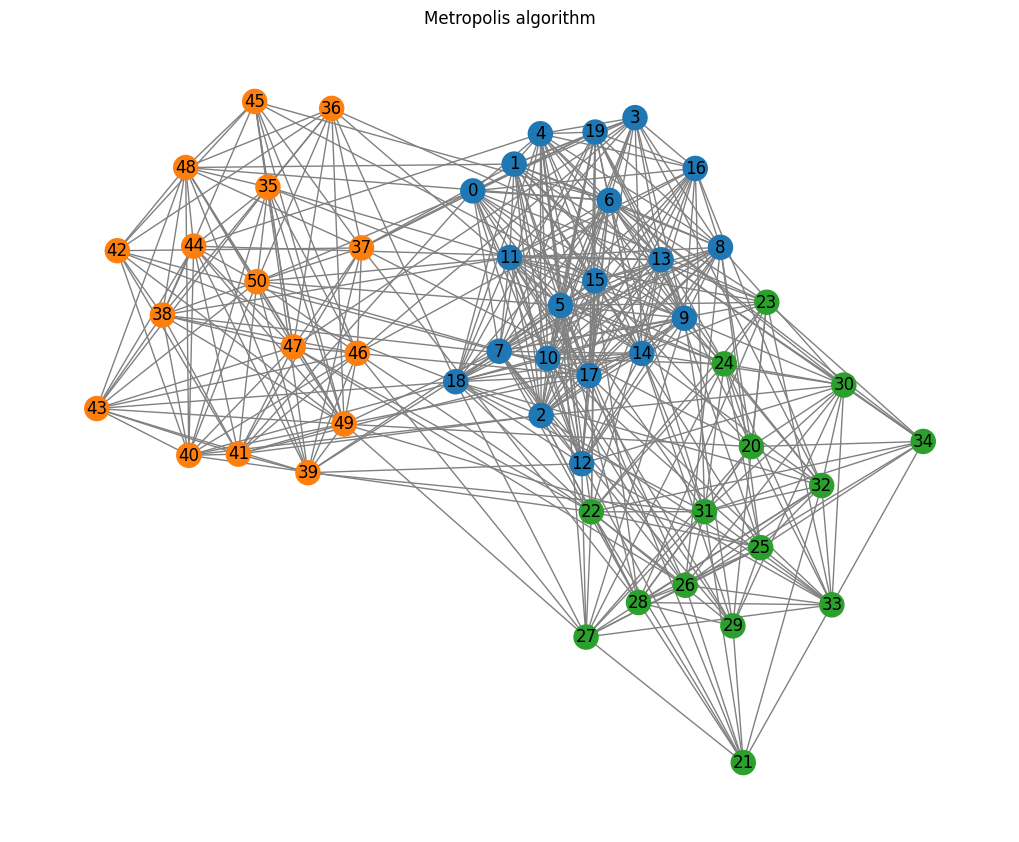

In [41]:
sizes = [20, 15, 16] 
probs = [
    [0.8, 0.25, 0.12], 
    [0.25, 0.6, 0.07],
    [0.12, 0.07, 0.7]
]

G = nx.stochastic_block_model(sizes, probs)
# G = nx.karate_club_graph()
A = nx.adjacency_matrix(G).toarray() 

final_partition = metropolis_algorithm(A, 3)
draw(final_partition, G, "Metropolis algorithm")
# final_partition = metropolis_hastings_algorithm(A, 2)
# draw(final_partition, G, "Metropolis Hasting algorithm")

<Figure size 800x600 with 0 Axes>

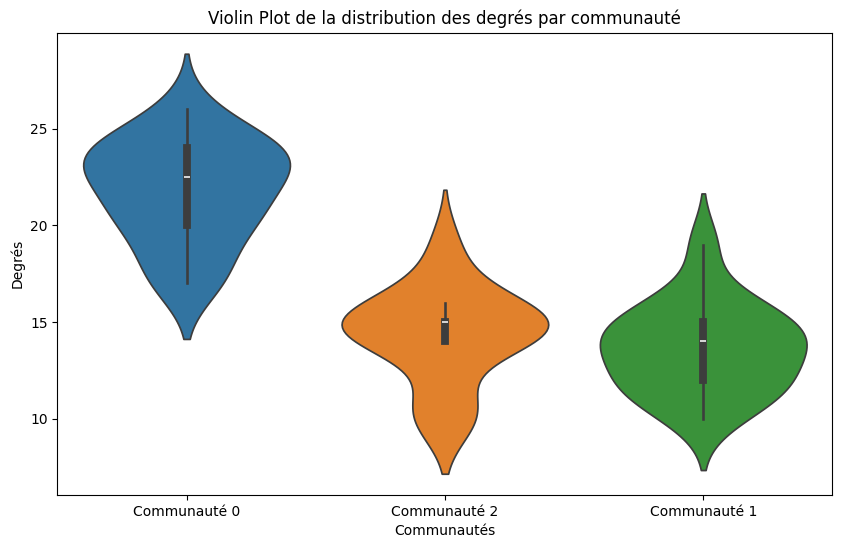

In [44]:
import seaborn as sns
# Organiser les degrés par communauté
community_degrees = {}
for i, community in enumerate(final_partition):
    if community not in community_degrees:
        community_degrees[community] = []
    community_degrees[community].append(G.degree(i))

# Création de l'histogramme avec des couleurs différentes pour chaque communauté
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red']  # Adaptez cette liste en fonction du nombre de communautés
labels = ['Communauté ' + str(i) for i in set(final_partition)]  # Générer des étiquettes dynamiquement

# Préparer les bins de l'histogramme
max_degree = max(max(degrees) for degrees in community_degrees.values())
bins = np.arange(0, max_degree + 2) - 0.5

# Supposons que community_degrees est déjà défini comme montré précédemment
data = [degrees for degrees in community_degrees.values()]
labels = ['Communauté ' + str(i) for i in community_degrees.keys()]

plt.figure(figsize=(10, 6))
sns.violinplot(data=data)
plt.xticks(range(len(labels)), labels)
plt.title('Violin Plot de la distribution des degrés par communauté')
plt.xlabel('Communautés')
plt.ylabel('Degrés')
plt.show()
